In [1]:
# Dataset testing

import h5py
import math
import matplotlib.pyplot as plt
import numpy as np
import scipy.fft as fft
import sigpy
import pynufft
import skimage
import os
import multiprocessing as mp
from multiprocessing import Pool
from PIL import Image
import tqdm
import glob
import seaborn as sns

from training.dataset import *
from dnnlib.util import *
from torch_utils import distributed as dist
from torch_utils import misc
import training.trajectory as trajectory
import training.visualize as visualize
import generate_conditional

device = torch.device('cuda')

import torchvision

import time

/home/trevor/miniconda3/envs/edm/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def make_trajectory_custom(matsize, undersampling=1, interleaves=1, alpha=1):

    fov = .22 #in meters
    # adjustedshape = np.power(matsize[0]**2+matsize[1]**2,0.5)
    adjustedshape = matsize[0]
    frequency_encode_undersampling = 1
    max_gradient_amp = 0.045 / 2#T/m  4.5 G/cm, or 2.2 G/cm       - Brian uses 0.040
    max_slew_rate = 0.2 * 1000 #T/m/s

    # u = .0365 / undersampling * (1-2*(((1/alpha)**4)-(1/alpha)**2)) # Empirically determined as a decent approximation for maintaining a steady effective undersampling rate
    # print(u)
    # u = u*10
    u = undersampling
    


    # points = sigpy.mri.spiral(fov, 
    #                         adjustedshape, 
    #                         frequency_encode_undersampling, 
    #                         u, 
    #                         interleaves, 
    #                         alpha, 
    #                         max_gradient_amp, 
    #                         max_slew_rate)
    
    points, t, dt, Tend, Dt = spiral(fov, 
                            adjustedshape, 
                            frequency_encode_undersampling, 
                            u, 
                            interleaves, 
                            alpha, 
                            max_gradient_amp, 
                            max_slew_rate)

    # points = np.asarray([i for i in points if -matsize[0]/2<=i[0]<=matsize[0]/2 and -matsize[1]/2<=i[1]<=matsize[1]/2]) # square 

    # points = np.delete(points, np.where((np.hypot(points[:,0],points[:,1]) >= matsize[0]/2)), axis=0) # circle
    
    # information_ratio = points.shape[0] / (matsize[0]*matsize[1]) #recalculate the new information sampling
    # print('information_ratio: {}'.format(information_ratio))

    return points, t, dt, Tend, Dt


def spiral(fov, N, f_sampling, R, ninterleaves, alpha, gm, sm, gamma=2.678e8):
    """Generate variable density spiral trajectory.

    Args:
        fov (float): field of view in meters.
        N (int): effective matrix shape.
        f_sampling (float): undersampling factor in freq encoding direction.
        R (float): undersampling factor.
        ninterleaves (int): number of spiral interleaves
        alpha (float): variable density factor
        gm (float): maximum gradient amplitude (T/m)
        sm (float): maximum slew rate (T/m/s)
        gamma (float): gyromagnetic ratio in rad/T/s

    Returns:
        array: spiral coordinates.

    References:
        Dong-hyun Kim, Elfar Adalsteinsson, and Daniel M. Spielman.
        'Simple Analytic Variable Density Spiral Design.' MRM 2003.

    """
    res = fov / N

    lam = 0.5 / res  # in m**(-1)
    n = 1 / (1 - (1 - ninterleaves * R / fov / lam) ** (1 / alpha))
    w = 2 * np.pi * n
    Tea = lam * w / gamma / gm / (alpha + 1)  # in s
    Tes = np.sqrt(lam * w**2 / sm / gamma) / (alpha / 2 + 1)  # in s
    Ts2a = (
        Tes ** ((alpha + 1) / (alpha / 2 + 1))
        * (alpha / 2 + 1)
        / Tea
        / (alpha + 1)
    ) ** (
        1 + 2 / alpha
    )  # in s

    if Ts2a < Tes:
        tautrans = (Ts2a / Tes) ** (1 / (alpha / 2 + 1))

        def tau(t):
            return (t / Tes) ** (1 / (alpha / 2 + 1)) * (0 <= t) * (
                t <= Ts2a
            ) + ((t - Ts2a) / Tea + tautrans ** (alpha + 1)) ** (
                1 / (alpha + 1)
            ) * (
                t > Ts2a
            ) * (
                t <= Tea
            ) * (
                Tes >= Ts2a
            )

        Tend = Tea
    else:

        def tau(t):
            return (t / Tes) ** (1 / (alpha / 2 + 1)) * (0 <= t) * (t <= Tes)

        Tend = Tes

    def k(t):
        return lam * tau(t) ** alpha * np.exp(w * tau(t) * 1j)

    dt = Tea * 1.0e-4  # in s

    Dt = dt * f_sampling / fov / abs(k(Tea) - k(Tea - dt))  # in s
    
    t = np.linspace(0, Tend, int(Tend / Dt))
    kt = k(t)  # in rad

    # generating cloned interleaves
    k = kt
    for i in range(1, ninterleaves):
        k = np.hstack((k, kt[0:] * np.exp(2 * np.pi * 1j * i / ninterleaves)))

    k = np.stack((np.real(k), np.imag(k)), axis=1)

    return k, t, dt, Tend, Dt

In [3]:
interleaves = 1

points, t, dt, Tend, Dt = make_trajectory_custom((128,128), undersampling=3, interleaves=interleaves, alpha=1.2)

In [4]:
points.shape

(4853, 2)

In [5]:
Tend * interleaves

0.007379610593582825

In [6]:
140 / 320 * 256 / 30

3.7333333333333334

In [7]:
# original scan time = TR / ETL * scanlines
# new scan time = time of spiral * interleaves

140 / 320 * 128 / 30 / (Tend*interleaves)


252.94920958158497

In [8]:
140 / 320 * 128 / 30

1.8666666666666667

In [9]:
def parameterize_acceleration_factor(accel_target = 20, interleaves = 4, alpha = 1.2, matsize = 256, reference_time = 112, threshold=0.001, correction = 1):
    accel = accel_target + 1
    undersampling = 1 * matsize / 256 * correction
    iter = 0
    while abs(accel_target-accel) > threshold * accel_target:
        points, t, dt, Tend, Dt = make_trajectory_custom((matsize,matsize), undersampling=undersampling, interleaves=interleaves, alpha=alpha)
        
        if accel_target-accel > 0:
            undersampling += 0.001 * np.clip((accel_target-accel),0.001,2)
        else:
            undersampling += 0.001 * np.clip((accel_target-accel),-2,-0.001)
                        
        accel = reference_time / (Tend*interleaves)
        iter += 1
        
        # print(accel)
        # print(undersampling)
    print(f'{iter} iterations')
    return undersampling, interleaves, alpha, accel

In [10]:
parameterize_acceleration_factor(accel_target = 64, interleaves = 20, alpha = 1.2, matsize = 128, reference_time = 3.8/2, threshold=0.001, correction = 1)

142 iterations


(0.7326805331447964, 20, 1.2, 63.94207339011882)

In [11]:
points, t, dt, Tend, Dt = make_trajectory_custom((128,128), undersampling=0.1, interleaves=30, alpha=1.2)

In [12]:
def make_trajectory_fixed_accel(matsize, reference_time, acceleration=1, interleaves=1, alpha=1):
    undersampling, _, _, _ = parameterize_acceleration_factor(accel_target = acceleration, interleaves = interleaves, alpha = alpha, matsize = matsize, reference_time = reference_time, threshold=0.001)
    points, _, _, Tend, Dt = make_trajectory_custom((matsize,matsize), undersampling=undersampling, interleaves=interleaves, alpha=alpha)
    print(f'Undersampling trajectory input: {undersampling}')
    return points, Dt, interleaves, alpha, Tend

In [13]:
def plot_trajectory_gradients(points, Dt, interleaves, alpha, Tend):
    import seaborn as sns
    # sns.set_palette('Greens_r')
    sns.set_palette('Reds_r')
    # sns.set_palette('Spectral')

    fig, ax = plt.subplots(1,1,figsize=(6,2))
    if interleaves == 1:
        width = 0.1
    else:
        width = 0.3
    # extent = 4800
    ax.plot(Dt*np.array(list(range(points.shape[0])[:points.shape[0]//interleaves])),points[:points.shape[0]//interleaves], linewidth=width, alpha=1)
    ax.plot(Dt*np.array(list(range(points.shape[0]))),points, linewidth=0.1, alpha=1)

    # ax.plot(Dt*np.array(list(range(points.shape[0]))),points[:,1], linewidth=0.2, alpha=1, color='orange')
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('kx, ky (1/m)')
    ax.text(0.995, 0.19, 'Interleaves: {}\nAlpha:   {}\nGradient Amplitude Cap: {} T/m\nGradient Slew Rate Cap: {} T/m/ms\nFOV: {} mm\nTime Interleave: {} ms\n'.format(interleaves, alpha, 0.045, 0.2, 220, str(round(Tend * 1000, 3))), 
            horizontalalignment='right', verticalalignment='center', transform=ax.transAxes, size=8)

In [14]:
def plot_trajectory_spiral(points, interleaves):
    if interleaves == 1:
        width = 0.1
    else:
        width = 0.3
    g = sns.JointGrid(height=5)
    sns.lineplot(x=points[:points.shape[0]//interleaves,0],y=points[:points.shape[0]//interleaves,1], ax=g.ax_joint, sort=False, alpha=1, linewidth=width)
    for i in range(1,interleaves):
        sns.lineplot(x=points[points.shape[0]//interleaves * i:points.shape[0]//interleaves * (i+1),0],y=points[points.shape[0]//interleaves * i:points.shape[0]//interleaves * (i+1),1],
                    ax=g.ax_joint, sort=False, alpha=1, linewidth=0.1)
    sns.histplot(x=points[:,0], alpha = 0.7, linewidth=0.1, ax=g.ax_marg_x)
    sns.histplot(y=points[:,1], alpha = 0.7, linewidth=0.1, ax=g.ax_marg_y)
    # sns.kdeplot(x=points[:points.shape[0]//interleaves,0],y=points[:points.shape[0]//interleaves,1], color="r", alpha=.1, levels=10, ax=g.ax_joint)
    # sns.scatterplot(x=points[:points.shape[0]//interleaves,0],y=points[:points.shape[0]//interleaves,1], color="b", marker = '.', s=10, alpha=0.5, ax=g.ax_joint, zorder=100)

    g.ax_joint.set_xlabel('kx (1/m)')
    g.ax_joint.set_ylabel('ky (1/m)')

In [15]:
accel_target = 200
interleaves = 30
alpha = 1.2
matsize = 256
reference_time = 3.8
# matsize = 128
# reference_time = 1.9

parameterize_acceleration_factor(accel_target = accel_target, interleaves = interleaves, alpha = alpha, matsize = matsize, reference_time = reference_time, threshold=0.001)
points, Dt, interleaves, alpha, Tend = make_trajectory_fixed_accel(matsize, reference_time, acceleration=accel_target, interleaves=interleaves, alpha=alpha)

1037 iterations
1037 iterations
Undersampling trajectory input: 3.0381555367112685


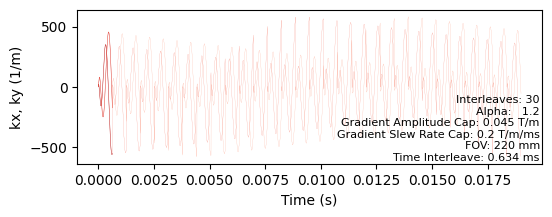

In [16]:
plot_trajectory_gradients(points, Dt, interleaves, alpha, Tend)

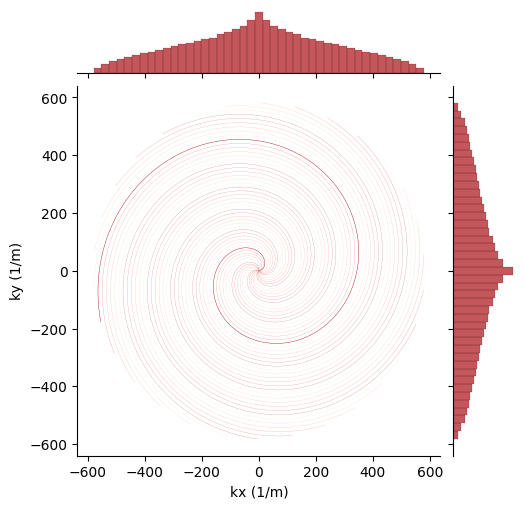

In [17]:
plot_trajectory_spiral(points, interleaves)

use 30 interleaves, use fewer shots